In [1]:
import os
import json
import ember
import adobe
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
data_dir = "/data/ember2018/"
emberdf = ember.read_metadata(data_dir)
X_train, y_train, X_test, y_test = ember.read_vectorized_features(data_dir)
lgbm_model = lgb.Booster(model_file=os.path.join(data_dir, "ember_model_2018.txt"))
y_test_pred = lgbm_model.predict(X_test)
y_train_pred = lgbm_model.predict(X_train)
emberdf["y_pred_ember"] = np.hstack((y_train_pred, y_test_pred))

In [59]:
nclasses = 15
detections = []
avclass_counts = emberdf[emberdf.subset == "train"].avclass.value_counts()
for i, family in enumerate(avclass_counts.index[:nclasses]):
    familydf = emberdf[(emberdf.subset == "test") & (emberdf.avclass == family)]
    detections.append((familydf.y_pred_ember > 0.8336).sum() / len(familydf))

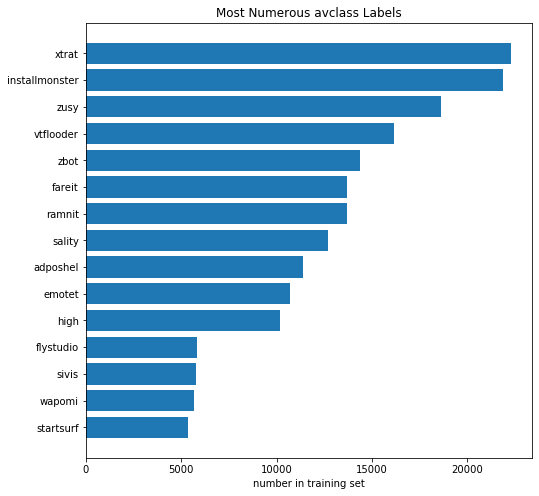

In [60]:
plt.figure(figsize=(8, 8))
plt.barh(np.arange(nclasses), avclass_counts[:nclasses], align='center')
plt.yticks(np.arange(nclasses))
plt.gca().set_yticklabels(avclass_counts.index[:nclasses])
plt.gca().invert_yaxis()  # labels read top-to-bottom
plt.xlabel('number in training set')
plt.title('Most Numerous avclass Labels')
plt.show()

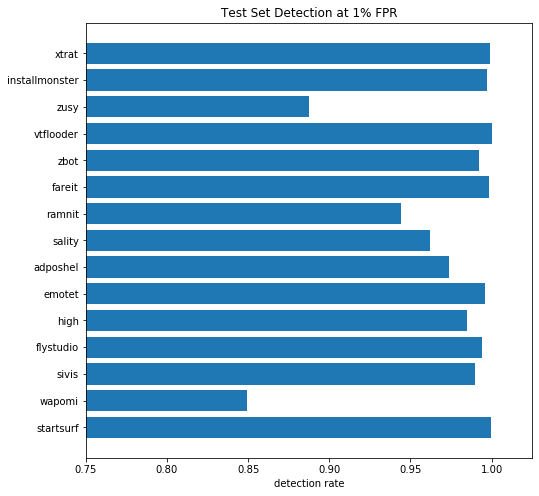

In [61]:
plt.figure(figsize=(8, 8))
plt.barh(np.arange(nclasses), detections, align='center')
plt.yticks(np.arange(nclasses))
plt.gca().set_yticklabels(avclass_counts.index[:nclasses])
plt.gca().invert_yaxis()  # labels read top-to-bottom
plt.xlim([0.75, 1.025])
plt.xlabel('detection rate')
plt.title('Test Set Detection at 1% FPR')
plt.show()

In [64]:
lgbm_model = lgb.Booster(model_file=os.path.join(data_dir, "ember_model_2018_weighted.txt"))
y_test_pred = lgbm_model.predict(X_test)
y_train_pred = lgbm_model.predict(X_train)
emberdf["y_pred_ember_weighted"] = np.hstack((y_train_pred, y_test_pred))

Original AUC: 0.9964289467999999
Weighted AUC: 0.9964181642000001


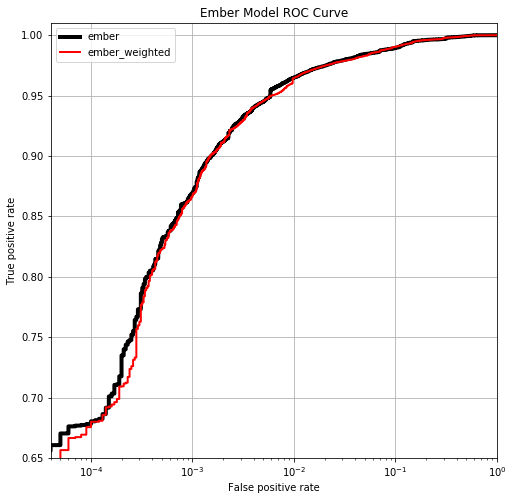

In [67]:
testdf = emberdf[emberdf["subset"] == "test"]
print(f"Original AUC: {roc_auc_score(testdf.label, testdf.y_pred_ember)}")
print(f"Weighted AUC: {roc_auc_score(testdf.label, testdf.y_pred_ember_weighted)}")

plt.figure(figsize=(8, 8))
fpr_plot, tpr_plot, _ = roc_curve(testdf.label, testdf.y_pred_ember)
plt.plot(fpr_plot, tpr_plot, lw=4, color='k', label="ember")
fpr_plot, tpr_plot, _ = roc_curve(testdf.label, testdf.y_pred_ember_weighted)
plt.plot(fpr_plot, tpr_plot, lw=2, color='r', label="ember_weighted")
plt.gca().set_xscale("log")
plt.yticks(np.arange(22) / 20.0)
plt.xlim([4e-5, 1.0])
plt.ylim([0.65, 1.01])
plt.legend(loc="best")
plt.gca().grid(True)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
_ = plt.title("Ember Model ROC Curve")

In [3]:
adobe_model = adobe.AdobeModel()
train_raw_feature_paths = [os.path.join(data_dir, "train_features_{}.jsonl".format(i)) for i in range(6)]
y_train_pred = adobe_model.predict_raw_features(map(json.loads, ember.raw_feature_iterator(train_raw_feature_paths)))
test_raw_feature_paths = [os.path.join(data_dir, "test_features.jsonl")]
y_test_pred = adobe_model.predict_raw_features(map(json.loads, ember.raw_feature_iterator(test_raw_feature_paths)))
emberdf["y_pred_adobe"] = np.hstack((y_train_pred, y_test_pred))

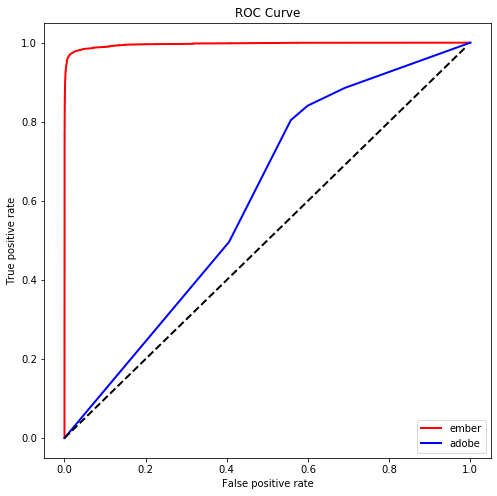

In [4]:
testdf = emberdf[emberdf["subset"] == "test"]
plt.figure(figsize=(8, 8))
fpr_plot_ember, tpr_plot_ember, _ = roc_curve(testdf.label, testdf.y_pred_ember)
fpr_plot_adobe, tpr_plot_adobe, _ = roc_curve(testdf.label, testdf.y_pred_adobe)
plt.plot(fpr_plot_ember, tpr_plot_ember, lw=2, color='r', label='ember')
plt.plot(fpr_plot_adobe, tpr_plot_adobe, lw=2, color='b', label='adobe')
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), lw=2, ls="dashed", color='k')
plt.legend(loc="best")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
_ = plt.title("ROC Curve")

In [5]:
X_train_adobe, y_train_adobe, X_test_adobe, y_test_adobe = adobe.read_vectorized_features(data_dir)
updated_adobe_model = lgb.Booster(model_file=os.path.join(data_dir, "adobe_model.txt"))
y_test_pred = updated_adobe_model.predict(X_test_adobe)
y_train_pred = updated_adobe_model.predict(X_train_adobe)
emberdf["y_pred_adobe_updated"] = np.hstack((y_train_pred, y_test_pred))

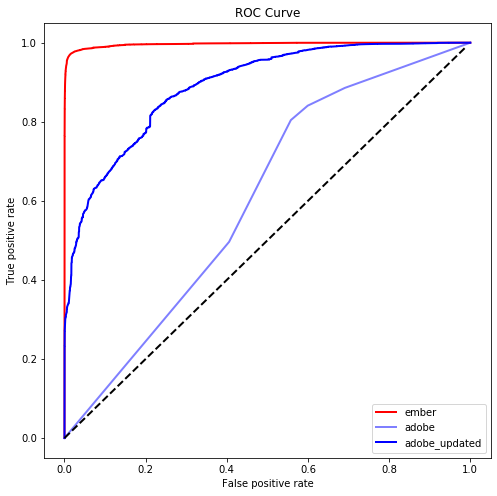

In [6]:
testdf = emberdf[emberdf["subset"] == "test"]
plt.figure(figsize=(8, 8))
fpr_plot_ember, tpr_plot_ember, _ = roc_curve(testdf.label, testdf.y_pred_ember)
fpr_plot_adobe, tpr_plot_adobe, _ = roc_curve(testdf.label, testdf.y_pred_adobe)
fpr_plot_adobe_updated, tpr_plot_adobe_updated, _ = roc_curve(testdf.label, testdf.y_pred_adobe_updated)
plt.plot(fpr_plot_ember, tpr_plot_ember, lw=2, color='r', label='ember')
plt.plot(fpr_plot_adobe, tpr_plot_adobe, lw=2, color='b', alpha=0.5, label='adobe')
plt.plot(fpr_plot_adobe_updated, tpr_plot_adobe_updated, lw=2, color='b', label='adobe_updated')
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), lw=2, ls="dashed", color='k')
plt.legend(loc="best")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
_ = plt.title("ROC Curve")

In [7]:
optimized_adobe_model = lgb.Booster(model_file=os.path.join(data_dir, "adobe_model_optimized.txt"))
y_test_pred = optimized_adobe_model.predict(X_test_adobe)
y_train_pred = optimized_adobe_model.predict(X_train_adobe)
emberdf["y_pred_adobe_optimized"] = np.hstack((y_train_pred, y_test_pred))

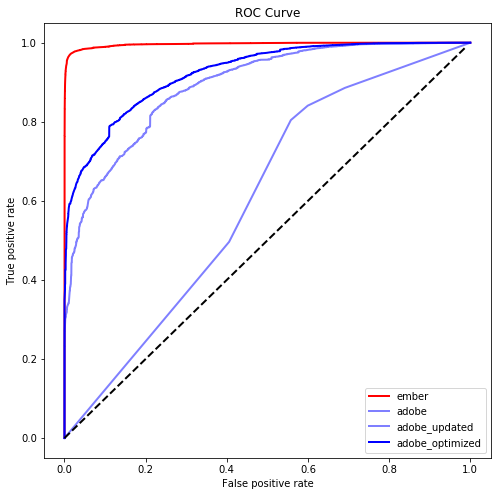

In [8]:
testdf = emberdf[emberdf["subset"] == "test"]
plt.figure(figsize=(8, 8))
fpr_plot_ember, tpr_plot_ember, _ = roc_curve(testdf.label, testdf.y_pred_ember)
fpr_plot_adobe, tpr_plot_adobe, _ = roc_curve(testdf.label, testdf.y_pred_adobe)
fpr_plot_adobe_updated, tpr_plot_adobe_updated, _ = roc_curve(testdf.label, testdf.y_pred_adobe_updated)
fpr_plot_adobe_optimized, tpr_plot_adobe_optimized, _ = roc_curve(testdf.label, testdf.y_pred_adobe_optimized)
plt.plot(fpr_plot_ember, tpr_plot_ember, lw=2, color='r', label='ember')
plt.plot(fpr_plot_adobe, tpr_plot_adobe, lw=2, color='b', alpha=0.5, label='adobe')
plt.plot(fpr_plot_adobe_updated, tpr_plot_adobe_updated, lw=2, color='b', alpha=0.5, label='adobe_updated')
plt.plot(fpr_plot_adobe_optimized, tpr_plot_adobe_optimized, lw=2, color='b', label='adobe_optimized')
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), lw=2, ls="dashed", color='k')
plt.legend(loc="best")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
_ = plt.title("ROC Curve")

Maximum prediction difference: 0.0073483582668516095


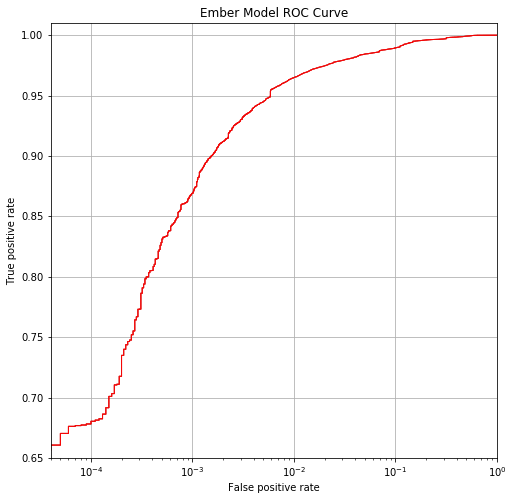

In [18]:
plt.figure(figsize=(8, 8))
fpr_plot, tpr_plot, _ = roc_curve(testdf.label, testdf.y_pred_ember)
plt.plot(fpr_plot, tpr_plot, lw=1, color='k', alpha=0.5, label="official")

max_prediction_diff = 0
for i in range(10):
    lgbm_model = lgb.Booster(model_file=os.path.join(data_dir, f"ember_model_2018_random{i}.txt"))
    y_test_pred_random = lgbm_model.predict(X_test)
    fpr_plot, tpr_plot, _ = roc_curve(testdf.label, y_test_pred_random)
    plt.plot(fpr_plot, tpr_plot, lw=1, color='r', alpha=0.25)
    max_prediction_diff = max(max_prediction_diff, np.abs(testdf.y_pred_ember - y_test_pred_random).max())


    
plt.gca().set_xscale("log")
plt.yticks(np.arange(22) / 20.0)
plt.xlim([4e-5, 1.0])
plt.ylim([0.65, 1.01])
plt.gca().grid(True)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Ember Model ROC Curve")

print(f"Maximum prediction difference: {max_prediction_diff}")

In [68]:
adobe.find_disagreements("/data/ember2018/", "/data/ember2018-select/samples/")

81a0f5837383fbddd26f7d8114d7acfbcbfe98357e8d646b7c0106f8ad95443c
VirtualSize2:     pefile: 450210 lief: 12
e02f983b96334a9b17069ba0f6dc4b95fc6e98b9c22282439666ffad4274b6ac
VirtualSize2:     pefile: 3174400 lief: 2297856
cba7391b257afb3e860447a995835e83561ea2c37ccdf2f460b235fcd856f767
NumberOfSections: pefile: 5 lief: 0
d20a0de799c85ce2881e18041e83a1320d6f837eb4cb9b2f54107e9ff6f3c052
NumberOfSections: pefile: 5 lief: 0
d1a2cc755fd53855df606b769536cbc3861eab87128c18668dbebc7c78c8a57a
VirtualSize2:     pefile: 79607 lief: 12
9036983d74deb79733849e03b01c2700b1924c20ed88b78acb6e9b3968d2f5d3
VirtualSize2:     pefile: 41424 lief: 592
a6f790a38bce7812932b84ddbc0644e4e9f95e1a537ab5163e0dd85c32a44d7a
VirtualSize2:     pefile: 0 lief: 188678144
8c2e7599b2b6d8481f7e0367927885b6fd8c6fa98207e7ebc712dced7394ab0d
VirtualSize2:     pefile: 2620555 lief: 637448
344c77fe8279524caed3b173e46486fffe3c9da68f63496ecff1e89138ecbf74
VirtualSize2:     pefile: 0 lief: 227668
884d40d9270cc131530ad63c1c7ef451595792

65ba6c95c0c498788d8452529fa04ed44225abdbe03189c38b02dc185d01f7ef
VirtualSize2:     pefile: 392712 lief: 12
c71240b35ca12af939c2c33be675f88f2c5ccfe3d72649df6bfae73cbe0658bd
VirtualSize2:     pefile: 3512 lief: 12
8ef1f16f5e97962efeef6600ad010c18e25652c101b4c13c5fe38f3d1de7e655
VirtualSize2:     pefile: 4096 lief: 204800
631d153549494a8978a9ef6db715bf8be1f4c9ff08683f41dbc41b6237c1ee27
VirtualSize2:     pefile: 6316 lief: 12
f22ff6ed906a9a589a926f8c74282df858ed49429e0a9c4850716a2841d18de5
VirtualSize2:     pefile: 40968 lief: 12
11064ae1c7a94b38fd4e6b1e9b6437a6a4901d996ea09a2bd7359033705b9151
VirtualSize2:     pefile: 44012 lief: 12
155f61830bab6610835345eb127168c1038acfe247a27a56cad9772d7a2d6e8a
VirtualSize2:     pefile: 38808 lief: 12
70ad83a59f5b80a784a3b2506713eb9ad7042ff5f29935bf8f7a6cf498e7e6f3
VirtualSize2:     pefile: 3480 lief: 12
99395dc7e71f612b7320ce3477ccaf5cfde11d05440834f89edc53cb627e6bde
VirtualSize2:     pefile: 4096 lief: 151552
824506c7eb45e8ff6402b9362c3905f7c4dd733d96